In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from dataLoader import SEN12MSCRTS

In [ ]:
root        = '/home/geo/Desktop/datasets/asiaWest'                 # path to your copy of SEN12MS-CR-TS
split       = 'train'                    # ROI to sample from, belonging to splits [all | train | val | test]
input_t     = 1                          # number of input time points to sample
region      = 'asiaWest'                 # choose the region of data input. [all | africa | america | asiaEast | asiaWest | europa]
import_path = None                       # path to importing the suppl. file specifying what time points to load for input and output
sample_type = 'cloudy_cloudfree'         # type of samples returned [cloudy_cloudfree | generic]

sen12mscrts = SEN12MSCRTS(root, split=split, sample_type=sample_type, cloud_masks='cloud_cloudshadow_mask' n_input_samples=input_t, region=region, import_data_path=import_path)
dataloader  = torch.utils.data.DataLoader(sen12mscrts, batch_size=8, shuffle=False, num_workers=1)


Processing paths for train split of region asiaWest


100%|██████████| 17/17 [00:00<00:00, 66021.45it/s]


In [ ]:
def get_rgb(image):
    image = image.mul(0.5).add_(0.5)
    image = image.squeeze()
    image = image.mul(10000).add_(0.5).clamp_(0, 10000)
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    image = image.astype(np.uint16)

    r = image[:,:,4]
    g = image[:,:,3]
    b = image[:,:,2]

    r = np.clip(r, 0, 10000)
    g = np.clip(g, 0, 10000)
    b = np.clip(b, 0, 10000)

    rgb = np.dstack((r, g, b))
    rgb = rgb - np.nanmin(rgb)

    # treat saturated images, scale values
    if np.nanmax(rgb) == 0:
        rgb = 255 * np.ones_like(rgb)
    else:
        rgb = 255 * (rgb / np.nanmax(rgb))

    # replace nan values before final conversion
    rgb[np.isnan(rgb)] = np.nanmean(rgb)
    rgb = rgb.astype(np.uint8)

    return rgb

def get_SAR(sar_image):
    sar_image = sar_image.cpu().detach().numpy()

    # Create a composite image from the two channels
    composite_image = np.zeros((256, 256, 3), dtype=np.float32)

    # Assign the first channel to the green channel
    composite_image[:,:,1] = sar_image[0]

    # Assign the second channel to the blue channel
    composite_image[:,:,2] = sar_image[1]

    return composite_image

In [ ]:
data = next(iter(dataloader))

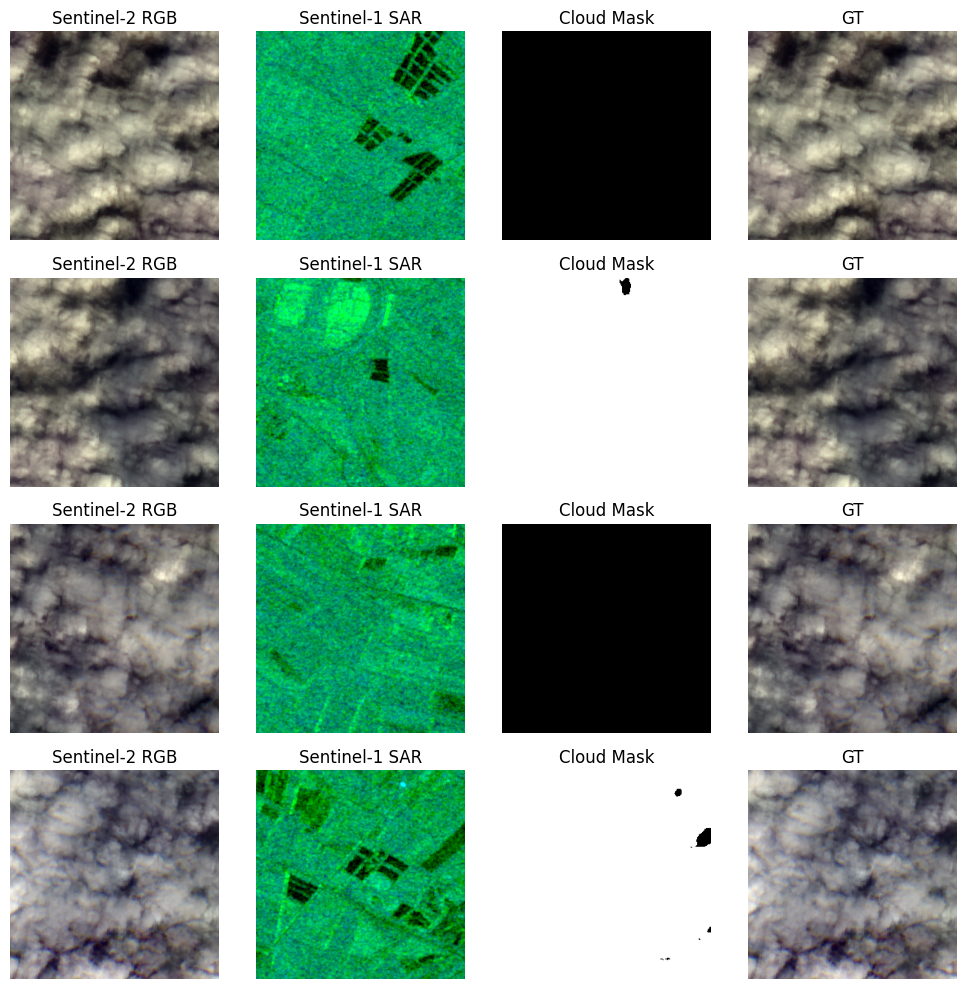

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, (ax1, ax2, ax3, ax4) in enumerate(axes):
    i+=4
    rgb, sar, mask, gt = get_rgb(data['input']['S2'][0][i]), get_SAR(data['input']['S1'][0][i]), data['input']['masks'][0][i], get_rgb(data['target']['S2'][0][i])

    ax1.imshow(rgb)
    ax1.set_title("Sentinel-2 RGB")
    ax1.axis('off')

    ax2.imshow(sar)
    ax2.set_title("Sentinel-1 SAR")
    ax2.axis('off')

    ax3.imshow(mask, cmap='gray')
    ax3.set_title("Cloud Mask")
    ax3.axis('off')

    ax4.imshow(gt)
    ax4.set_title("GT")
    ax4.axis('off')

plt.tight_layout()
plt.show()